In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# open data
tries = 1

def open_data(folder_name):
    output = {}
    with open(f"{folder_name}/coins.pkl", "rb") as f:
        output["coins"] = pickle.load(f)
    with open(f"{folder_name}/alphas.pkl", "rb") as f:
        output["alphas"] = pickle.load(f)
    with open(f"{folder_name}/errors.pkl", "rb") as f:
        output["errors"] = pickle.load(f)
    with open(f"{folder_name}/success.pkl", "rb") as f:
        output["success"] = pickle.load(f)
    with open(f"{folder_name}/c_list.pkl", "rb") as f:
        output["c_list"] = pickle.load(f)
    return output
        
data = []
exp_list = [0.5, 1, 1.5]
B_exp = 9
N = 5000
for exp in exp_list:
    folder_name = f"results/BaySS/find_alpha_{tries}/N_{N}/B_exp_{B_exp}/eps_{exp:.1f}"
    output=open_data(folder_name)
    data.append(output)

# Success rate

In [3]:
def get_binomial_std(p, n):
    return np.sqrt(p*(1-p)/n)

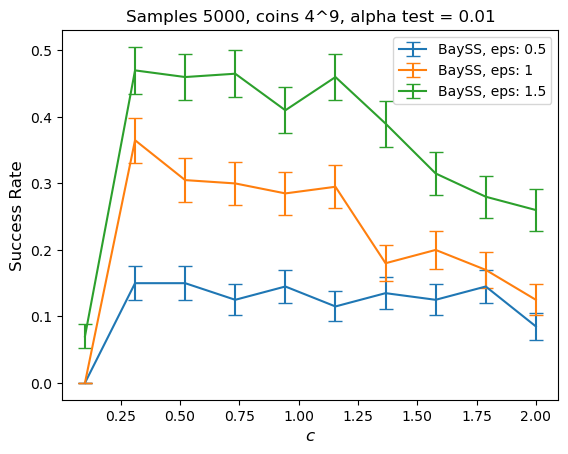

In [6]:
# folder_name = "success_vs_eps"
# os.makedirs(f"figures/{folder_name}", exist_ok=True)
# figure_name = f"N_{N}_Bexp_{B_exp}_alpha_{alpha}.pdf"
for i, output in enumerate(data):
    success = output["success"]
    c_list = output["c_list"]
    plt.errorbar(c_list, 
                 np.mean(success, axis=1), 
                 yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]), 
                 fmt="-", 
                 label=f"BaySS, eps: {exp_list[i]}", 
                 capsize=5)
# plt.errorbar(c_list, 
#              np.mean(success, axis=1), 
#              yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]), 
#              fmt="-", 
#              label="BaySS", 
#              capsize=5)

plt.xlabel(r'$c$', fontsize = 12)
plt.ylabel('Success Rate', fontsize = 12)
plt.title(f"Samples {N}, coins 4^{B_exp}, alpha test = 0.01")
plt.legend()

# save fig
folder_name = "find_alpha"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/success_vs_eps_N_{N}_Bexp_{B_exp}.pdf")
plt.show()

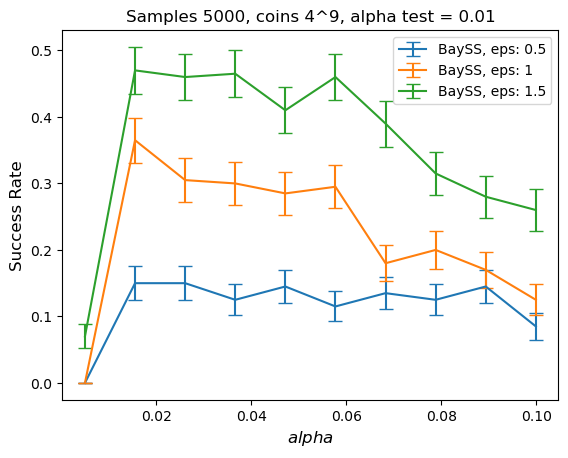

In [5]:
# folder_name = "success_vs_eps"
# os.makedirs(f"figures/{folder_name}", exist_ok=True)
# figure_name = f"N_{N}_Bexp_{B_exp}_alpha_{alpha}.pdf"
for i, output in enumerate(data):
    success = output["success"]
    alpha_list = output["alphas"]
    plt.errorbar(alpha_list, 
                 np.mean(success, axis=1), 
                 yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]), 
                 fmt="-", 
                 label=f"BaySS, eps: {exp_list[i]}", 
                 capsize=5)
# plt.errorbar(c_list, 
#              np.mean(success, axis=1), 
#              yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]), 
#              fmt="-", 
#              label="BaySS", 
#              capsize=5)

plt.xlabel(r'$alpha$', fontsize = 12)
plt.ylabel('Success Rate', fontsize = 12)
plt.title(f"Samples {N}, coins 4^{B_exp}, alpha test = 0.01")
plt.legend()
# plt.savefig(os.path.join("figures", folder_name, figure_name))
plt.show()

# Error vs. $\varepsilon$ plot

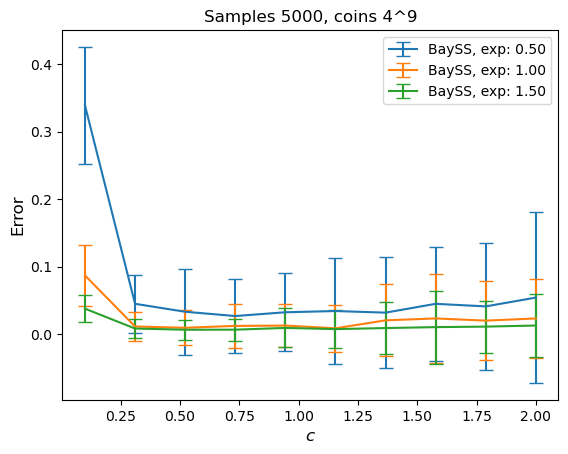

In [7]:
# folder_name = "error_vs_eps"
# os.makedirs(f"figures/{folder_name}", exist_ok=True)
# figure_name = f"N_{N}_Bexp_{B_exp}_alpha_{alpha}.pdf"
for i, output in enumerate(data):
    errors = output["errors"]
    c_list = output["c_list"]
    plt.errorbar(c_list, 
                 np.mean(errors, axis=1), 
                 yerr=np.std(errors, axis=1), 
                 fmt="-", 
                 label=f"BaySS, exp: {exp_list[i]:.2f}", 
                 capsize=5)
plt.xlabel(r'$c$', fontsize = 12)
plt.ylabel('Error', fontsize = 12)
plt.title(f"Samples {N}, coins 4^{B_exp}")
plt.legend()
# plt.savefig(os.path.join("figures", folder_name, figure_name))

folder_name = "find_alpha"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/errors_N_{N}_Bexp_{B_exp}_eps_{eps}.pdf")

plt.show()

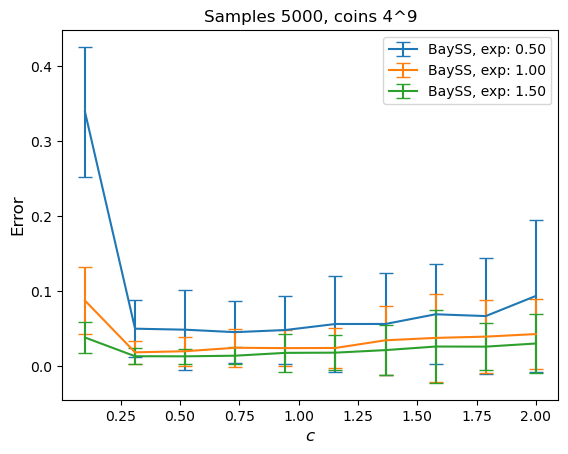

In [25]:
# folder_name = "error_vs_eps"
# os.makedirs(f"figures/{folder_name}", exist_ok=True)
# figure_name = f"N_{N}_Bexp_{B_exp}_alpha_{alpha}.pdf"
for i, output in enumerate(data):
    errors = output["errors"]
    c_list = output["c_list"]
    plt.errorbar(c_list, 
                 np.mean(np.abs(errors), axis=1), 
                 yerr=np.std(np.abs(errors), axis=1), 
                 fmt="-", 
                 label=f"BaySS, exp: {exp_list[i]:.2f}", 
                 capsize=5)
plt.xlabel(r'$c$', fontsize = 12)
plt.ylabel('Error', fontsize = 12)
plt.title(f"Samples {N}, coins 4^{B_exp}")
plt.legend()
# plt.savefig(os.path.join("figures", folder_name, figure_name))
plt.show()

# CDF of errors

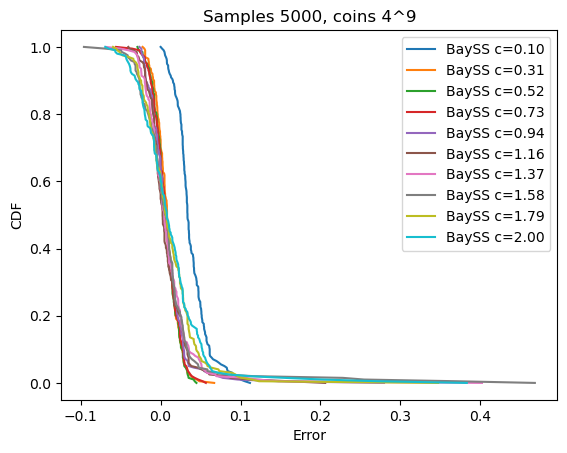

In [10]:
for error, c in zip(errors, c_list):
    error = np.sort(error)
    error = error[::-1]
    plt.plot(error, np.linspace(0, 1, len(error)), label=f"BaySS c={c:.2f}")
plt.xlabel('Error')
plt.ylabel('CDF')
plt.title(f"Samples {N}, coins 4^{B_exp}")
plt.legend()
plt.show()